In [ ]:
!pip install torch matplotlib tqdm

In [ ]:
!pip install wget

In [5]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

from nerf_model import TinyNerfModel
from nerf_dataset import TinyCybertruckDataset, TinyLegoDataset
from nerf_functions import get_rays, render_rays

In [6]:
# Setting seed because model is sensitive to initialization
seed = 5
torch.manual_seed(seed)

In [7]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using device:", torch.cuda.get_device_name(0))
elif torch.backends.mps.is_available(): 
    # device = torch.device("mps")
    # CPU might be faster for some Mac users
    device = torch.device("cpu")
    print("Using device: Apple Silicon GPU")
else:
    device = torch.device('cpu')
    print("Using device: CPU")

Using device: Apple Silicon GPU


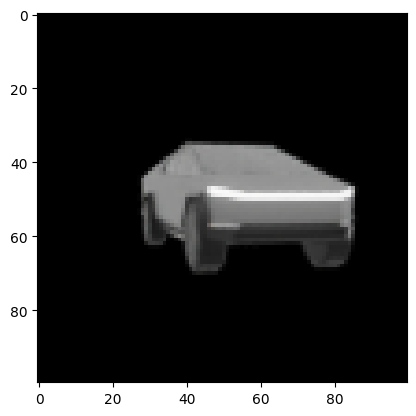

In [8]:
train_data = TinyCybertruckDataset()
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)

testimg, testpose, testfocal = TinyCybertruckDataset(split='test')[0]
testpose = testpose.to(device)

plt.imshow(testimg)
plt.show()

In [9]:
model = TinyNerfModel()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
loss_fn = torch.nn.MSELoss()

In [10]:
# Using Xavier initialization because model performs better (found out through trial and error)
# https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.xavier_uniform_
for m in model.modules():
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.zeros_(m.bias)

In [11]:
model = model.to(device)

Epoch 0


100%|██████████| 105/105 [13:21<00:00,  7.63s/it]


Epoch took 801.5436520576477 seconds, Loss: 0.010680009610950947


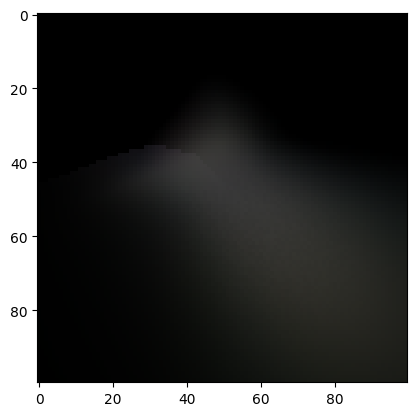

Epoch 1


100%|██████████| 105/105 [14:03<00:00,  8.03s/it]


Epoch took 843.6075468063354 seconds, Loss: 0.01397005282342434


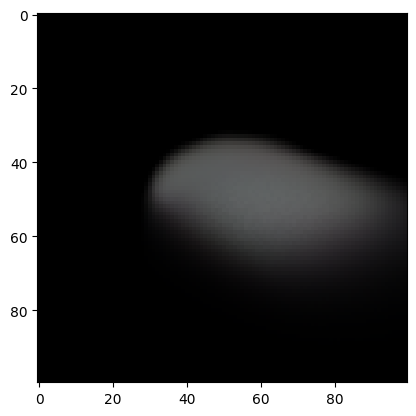

Epoch 2


 28%|██▊       | 29/105 [04:00<10:30,  8.29s/it]


KeyboardInterrupt: 

In [12]:
NUM_EPOCHS = 10
near, far = train_data.get_near_far()
H, W = train_data.get_image_size()
N_samples = 64


for i in range(NUM_EPOCHS):
    print(f"Epoch {i}")
    start_time = time.time()
    
    for target_image, pose, focal in tqdm(train_dataloader):
        target_image = target_image.to(device)
        pose = pose.squeeze().to(device)
        focal = focal.to(device)

        rays_o, rays_d = get_rays(H, W, focal, pose, device=device)
        rgb_map = render_rays(model, rays_o, rays_d, near, far, N_samples, device=device)
        
        loss = loss_fn(rgb_map, target_image.squeeze())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch took {time.time() - start_time} seconds, Loss: {loss.item()}")
    with torch.no_grad():
        rays_o, rays_d = get_rays(H, W, testfocal, testpose, device=device)
        rgb = render_rays(model, rays_o, rays_d, near, far, N_samples, device=device)
        plt.imshow(rgb.cpu().numpy())
        plt.show()

